**Import Libraries**

In [55]:
import pandas as pd
import numpy as np
import pickle
import gc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

**MOUNT GOOGLE DRIVE**

In [56]:
from google.colab import drive
drive.mount('/content/drive')

import os
project_folder = '/content/drive/MyDrive/FraudDetection'  # Sesuaikan dengan folder kamu
os.chdir(project_folder)

print(f"Working Directory: {os.getcwd()}")
print("\n✅ Google Drive mounted!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Working Directory: /content/drive/MyDrive/FraudDetection

✅ Google Drive mounted!


**LOAD PROCESSED DATA (IN CHUNKS TO SAVE RAM)**

In [57]:
print("\n" + "=" * 60)
print("LOADING PROCESSED DATA")
print("=" * 60)

# Load training data
print("Loading training data...")
X_train = pd.read_csv('data/processed/X_train_balanced.csv', dtype=np.float32)
y_train = pd.read_csv('data/processed/y_train_balanced.csv')['isFraud'].values

print(f"✓ X_train: {X_train.shape}")
print(f"✓ y_train: {y_train.shape}")
print(f"✓ Memory: {X_train.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Load validation data
print("\nLoading validation data...")
X_val = pd.read_csv('data/processed/X_val_scaled.csv', dtype=np.float32)
y_val = pd.read_csv('data/processed/y_val.csv')['isFraud'].values

print(f"✓ X_val: {X_val.shape}")
print(f"✓ y_val: {y_val.shape}")
print(f"✓ Memory: {X_val.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


LOADING PROCESSED DATA
Loading training data...
✓ X_train: (911804, 163)
✓ y_train: (911804,)
✓ Memory: 566.96 MB

Loading validation data...
✓ X_val: (118108, 163)
✓ y_val: (118108,)
✓ Memory: 73.44 MB


**MEMORY CHECK & OPTIMIZATION**

In [58]:
print("\n" + "=" * 60)
print("MEMORY OPTIMIZATION")
print("=" * 60)

# Convert to numpy arrays to save memory
X_train_np = X_train.values.astype(np.float32)
X_val_np = X_val.values.astype(np.float32)

# Delete DataFrames
del X_train, X_val
gc.collect()

print(f"✓ Converted to numpy arrays")
print(f"✓ X_train memory: {X_train_np.nbytes / 1024**2:.2f} MB")
print(f"✓ X_val memory: {X_val_np.nbytes / 1024**2:.2f} MB")
print(f"✓ Total memory: {(X_train_np.nbytes + X_val_np.nbytes) / 1024**2:.2f} MB")


MEMORY OPTIMIZATION
✓ Converted to numpy arrays
✓ X_train memory: 566.96 MB
✓ X_val memory: 73.44 MB
✓ Total memory: 640.39 MB


**MODEL 1: LIGHTGBM (MOST MEMORY-EFFICIENT)**

In [59]:
print("\n" + "=" * 60)
print("MODEL 1: LIGHTGBM (MEMORY-EFFICIENT)")
print("=" * 60)

# Start with a simple baseline model
print("\nTraining baseline LightGBM...")

lgb_baseline = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=7,
    learning_rate=0.1,
    num_leaves=31,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgb_baseline.fit(X_train_np, y_train)
print("✓ Baseline LightGBM trained!")

# Evaluate on validation set
y_pred_lgb = lgb_baseline.predict(X_val_np)
y_pred_proba_lgb = lgb_baseline.predict_proba(X_val_np)[:, 1]

# Calculate metrics
precision_lgb = precision_score(y_val, y_pred_lgb)
recall_lgb = recall_score(y_val, y_pred_lgb)
f1_lgb = f1_score(y_val, y_pred_lgb)
auc_lgb = roc_auc_score(y_val, y_pred_proba_lgb)

print(f"\nBaseline LightGBM Results:")
print(f"  Precision: {precision_lgb:.4f}")
print(f"  Recall: {recall_lgb:.4f}")
print(f"  F1-Score: {f1_lgb:.4f}")
print(f"  AUC-ROC: {auc_lgb:.4f}")

# Save baseline model immediately
with open('models/lgb_baseline.pkl', 'wb') as f:
    pickle.dump(lgb_baseline, f)
print("\n💾 Saved: models/lgb_baseline.pkl")

# Save baseline results
baseline_results = {
    'model': 'LightGBM_Baseline',
    'precision': precision_lgb,
    'recall': recall_lgb,
    'f1_score': f1_lgb,
    'auc_roc': auc_lgb
}

with open('results/05_lgb_baseline_results.pkl', 'wb') as f:
    pickle.dump(baseline_results, f)

# Clear memory
del lgb_baseline, y_pred_lgb
gc.collect()


MODEL 1: LIGHTGBM (MEMORY-EFFICIENT)

Training baseline LightGBM...
✓ Baseline LightGBM trained!

Baseline LightGBM Results:
  Precision: 0.4732
  Recall: 0.5171
  F1-Score: 0.4942
  AUC-ROC: 0.8878

💾 Saved: models/lgb_baseline.pkl


39

**HYPERPARAMETER TUNING - LIGHTGBM (MEMORY-SAFE)**

In [60]:
print("\n" + "=" * 60)
print("HYPERPARAMETER TUNING - LIGHTGBM")
print("=" * 60)

# Use RandomizedSearchCV with SMALL n_iter to avoid RAM crash
print("\n⚠️ Using memory-safe tuning strategy:")
print("  - RandomizedSearchCV (not GridSearch)")
print("  - n_iter=5 (only 5 combinations)")
print("  - cv=3 (3-fold CV)")
print("  - Incremental saving after each iteration")

param_dist_lgb = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 70],
    'min_child_samples': [20, 30, 50],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

print("\nStarting RandomizedSearchCV...")
print("This will take several minutes...")

lgb_model = lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)

random_search_lgb = RandomizedSearchCV(
    lgb_model,
    param_distributions=param_dist_lgb,
    n_iter=5,  # SMALL number to prevent RAM crash
    cv=3,
    scoring='f1',
    random_state=42,
    n_jobs=1,  # Single job to control memory
    verbose=2
)

random_search_lgb.fit(X_train_np, y_train)
print("\n✓ Hyperparameter tuning completed!")

# Get best model
best_lgb = random_search_lgb.best_estimator_
best_params_lgb = random_search_lgb.best_params_

print(f"\nBest Parameters:")
for param, value in best_params_lgb.items():
    print(f"  {param}: {value}")

# Evaluate best model
y_pred_lgb_tuned = best_lgb.predict(X_val_np)
y_pred_proba_lgb_tuned = best_lgb.predict_proba(X_val_np)[:, 1]

precision_lgb_tuned = precision_score(y_val, y_pred_lgb_tuned)
recall_lgb_tuned = recall_score(y_val, y_pred_lgb_tuned)
f1_lgb_tuned = f1_score(y_val, y_pred_lgb_tuned)
auc_lgb_tuned = roc_auc_score(y_val, y_pred_proba_lgb_tuned)

print(f"\nTuned LightGBM Results:")
print(f"  Precision: {precision_lgb_tuned:.4f}")
print(f"  Recall: {recall_lgb_tuned:.4f}")
print(f"  F1-Score: {f1_lgb_tuned:.4f}")
print(f"  AUC-ROC: {auc_lgb_tuned:.4f}")

# Save tuned model immediately
with open('models/lgb_tuned.pkl', 'wb') as f:
    pickle.dump(best_lgb, f)
print("\n💾 Saved: models/lgb_tuned.pkl")

# Save tuning results
tuned_results = {
    'model': 'LightGBM_Tuned',
    'best_params': best_params_lgb,
    'precision': precision_lgb_tuned,
    'recall': recall_lgb_tuned,
    'f1_score': f1_lgb_tuned,
    'auc_roc': auc_lgb_tuned
}

with open('results/05_lgb_tuned_results.pkl', 'wb') as f:
    pickle.dump(tuned_results, f)

# Clear memory before next model
del random_search_lgb, best_lgb, y_pred_lgb_tuned, y_pred_proba_lgb_tuned
gc.collect()

print("\n✓ Memory cleared")


HYPERPARAMETER TUNING - LIGHTGBM

⚠️ Using memory-safe tuning strategy:
  - RandomizedSearchCV (not GridSearch)
  - n_iter=5 (only 5 combinations)
  - cv=3 (3-fold CV)
  - Incremental saving after each iteration

Starting RandomizedSearchCV...
This will take several minutes...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, min_child_samples=50, n_estimators=200, num_leaves=31, subsample=0.9; total time=  57.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, min_child_samples=50, n_estimators=200, num_leaves=31, subsample=0.9; total time=  57.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, min_child_samples=50, n_estimators=200, num_leaves=31, subsample=0.9; total time=  56.6s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=50, n_estimators=200, num_leaves=50, subsample=1.0; total time=  39.9s
[CV] END colsample_bytree=0.9, learning_rate=0.

**MODEL 2: XGBOOST (MEMORY-EFFICIENT)**

In [61]:
print("\n" + "=" * 60)
print("MODEL 2: XGBOOST")
print("=" * 60)

# Baseline XGBoost
print("\nTraining baseline XGBoost...")

xgb_baseline = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=7,
    learning_rate=0.1,
    random_state=42,
    tree_method='hist',  # Memory-efficient
    n_jobs=-1,
    verbosity=0
)

xgb_baseline.fit(X_train_np, y_train)
print("✓ Baseline XGBoost trained!")

# Evaluate
y_pred_xgb = xgb_baseline.predict(X_val_np)
y_pred_proba_xgb = xgb_baseline.predict_proba(X_val_np)[:, 1]

precision_xgb = precision_score(y_val, y_pred_xgb)
recall_xgb = recall_score(y_val, y_pred_xgb)
f1_xgb = f1_score(y_val, y_pred_xgb)
auc_xgb = roc_auc_score(y_val, y_pred_proba_xgb)

print(f"\nBaseline XGBoost Results:")
print(f"  Precision: {precision_xgb:.4f}")
print(f"  Recall: {recall_xgb:.4f}")
print(f"  F1-Score: {f1_xgb:.4f}")
print(f"  AUC-ROC: {auc_xgb:.4f}")

# Save immediately
with open('models/xgb_baseline.pkl', 'wb') as f:
    pickle.dump(xgb_baseline, f)
print("\n💾 Saved: models/xgb_baseline.pkl")

xgb_baseline_results = {
    'model': 'XGBoost_Baseline',
    'precision': precision_xgb,
    'recall': recall_xgb,
    'f1_score': f1_xgb,
    'auc_roc': auc_xgb
}

with open('results/05_xgb_baseline_results.pkl', 'wb') as f:
    pickle.dump(xgb_baseline_results, f)

# Clear memory
del xgb_baseline, y_pred_xgb, y_pred_proba_xgb
gc.collect()


MODEL 2: XGBOOST

Training baseline XGBoost...
✓ Baseline XGBoost trained!

Baseline XGBoost Results:
  Precision: 0.5037
  Recall: 0.5480
  F1-Score: 0.5249
  AUC-ROC: 0.9047

💾 Saved: models/xgb_baseline.pkl


68

**HYPERPARAMETER TUNING - XGBOOST (MEMORY-SAFE)**

In [62]:
print("\n" + "=" * 60)
print("HYPERPARAMETER TUNING - XGBOOST")
print("=" * 60)

param_dist_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5]
}

print("\nStarting RandomizedSearchCV for XGBoost...")

xgb_model = xgb.XGBClassifier(
    random_state=42,
    tree_method='hist',
    n_jobs=-1,
    verbosity=0
)

random_search_xgb = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist_xgb,
    n_iter=5,  # SMALL to prevent crash
    cv=3,
    scoring='f1',
    random_state=42,
    n_jobs=1,
    verbose=2
)

random_search_xgb.fit(X_train_np, y_train)
print("\n✓ XGBoost tuning completed!")

best_xgb = random_search_xgb.best_estimator_
best_params_xgb = random_search_xgb.best_params_

print(f"\nBest Parameters:")
for param, value in best_params_xgb.items():
    print(f"  {param}: {value}")

# Evaluate
y_pred_xgb_tuned = best_xgb.predict(X_val_np)
y_pred_proba_xgb_tuned = best_xgb.predict_proba(X_val_np)[:, 1]

precision_xgb_tuned = precision_score(y_val, y_pred_xgb_tuned)
recall_xgb_tuned = recall_score(y_val, y_pred_xgb_tuned)
f1_xgb_tuned = f1_score(y_val, y_pred_xgb_tuned)
auc_xgb_tuned = roc_auc_score(y_val, y_pred_proba_xgb_tuned)

print(f"\nTuned XGBoost Results:")
print(f"  Precision: {precision_xgb_tuned:.4f}")
print(f"  Recall: {recall_xgb_tuned:.4f}")
print(f"  F1-Score: {f1_xgb_tuned:.4f}")
print(f"  AUC-ROC: {auc_xgb_tuned:.4f}")

# Save immediately
with open('models/xgb_tuned.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)
print("\n💾 Saved: models/xgb_tuned.pkl")

xgb_tuned_results = {
    'model': 'XGBoost_Tuned',
    'best_params': best_params_xgb,
    'precision': precision_xgb_tuned,
    'recall': recall_xgb_tuned,
    'f1_score': f1_xgb_tuned,
    'auc_roc': auc_xgb_tuned
}

with open('results/05_xgb_tuned_results.pkl', 'wb') as f:
    pickle.dump(xgb_tuned_results, f)

# Clear memory
del random_search_xgb, best_xgb, y_pred_xgb_tuned, y_pred_proba_xgb_tuned
gc.collect()

print("\n✓ Memory cleared")


HYPERPARAMETER TUNING - XGBOOST

Starting RandomizedSearchCV for XGBoost...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=10, min_child_weight=3, n_estimators=100, subsample=0.8; total time=  59.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=10, min_child_weight=3, n_estimators=100, subsample=0.8; total time=  53.4s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=10, min_child_weight=3, n_estimators=100, subsample=0.8; total time=  51.0s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=10, min_child_weight=3, n_estimators=200, subsample=0.9; total time= 1.5min
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=10, min_child_weight=3, n_estimators=200, subsample=0.9; total time= 1.4min
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=10, min_child_weight=3, n_estimators=200, subsample=0.9; total time= 1.4min
[CV] END colsample_bytree=1.0, learning_r

**MODEL COMPARISON**


MODEL COMPARISON

            Model  Precision   Recall  F1-Score  AUC-ROC
LightGBM Baseline   0.473206 0.517058  0.494161 0.887825
   LightGBM Tuned   0.601598 0.510041  0.552049 0.908827
 XGBoost Baseline   0.503669 0.548028  0.524913 0.904750
    XGBoost Tuned   0.663119 0.557706  0.605861 0.929680

💾 Saved: results/05_model_comparison.csv
📊 Saved: visualizations/05_model_comparison.png


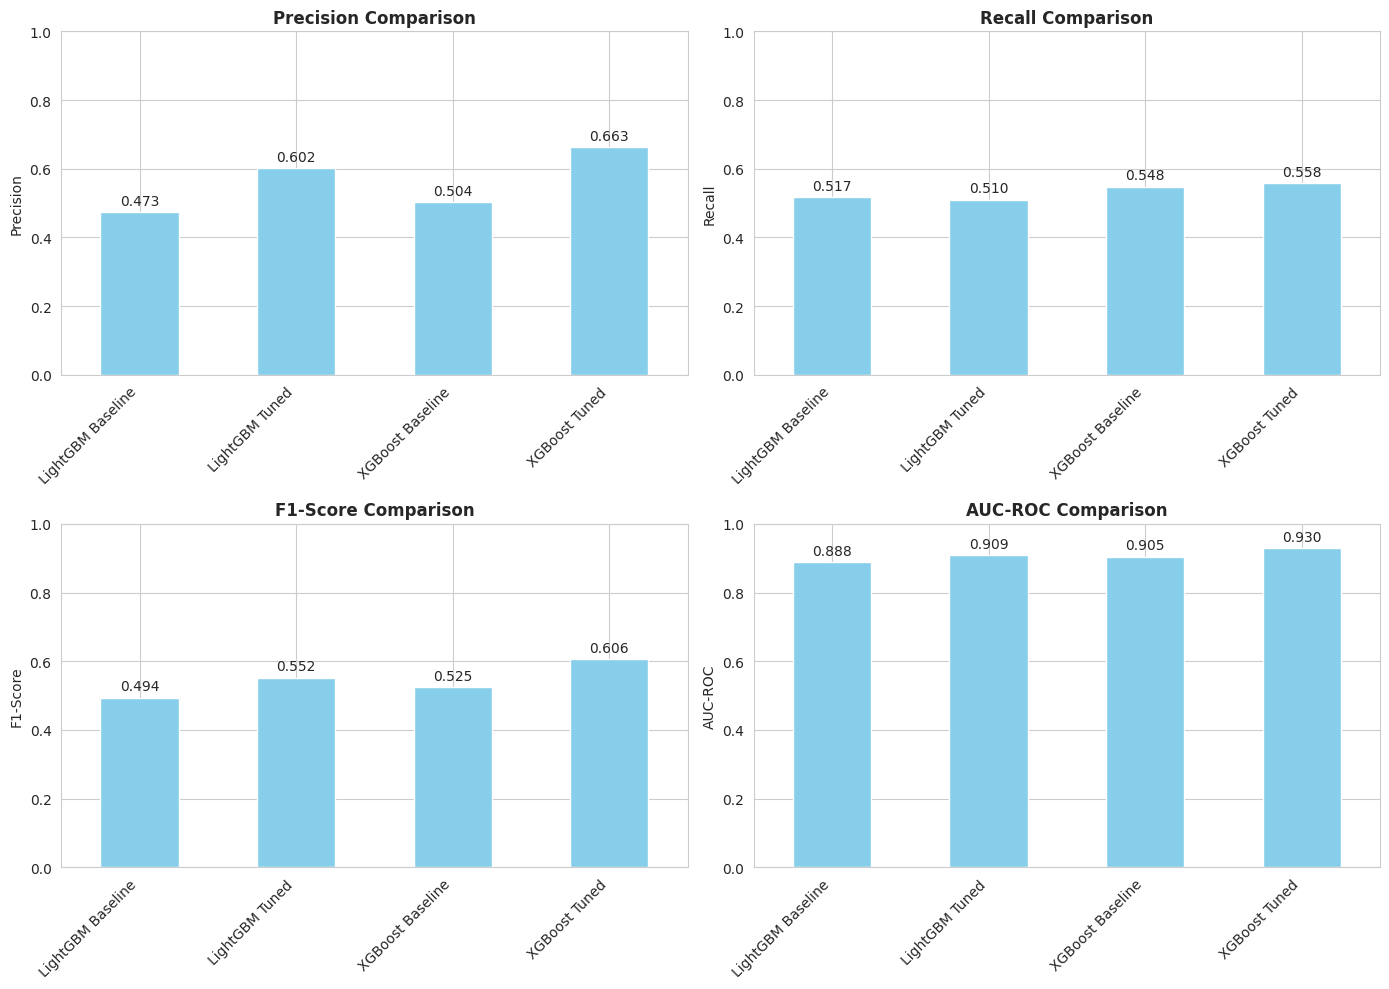

In [63]:
print("\n" + "=" * 60)
print("MODEL COMPARISON")
print("=" * 60)

# Create comparison DataFrame
comparison_data = {
    'Model': [
        'LightGBM Baseline',
        'LightGBM Tuned',
        'XGBoost Baseline',
        'XGBoost Tuned'
    ],
    'Precision': [
        baseline_results['precision'],
        tuned_results['precision'],
        xgb_baseline_results['precision'],
        xgb_tuned_results['precision']
    ],
    'Recall': [
        baseline_results['recall'],
        tuned_results['recall'],
        xgb_baseline_results['recall'],
        xgb_tuned_results['recall']
    ],
    'F1-Score': [
        baseline_results['f1_score'],
        tuned_results['f1_score'],
        xgb_baseline_results['f1_score'],
        xgb_tuned_results['f1_score']
    ],
    'AUC-ROC': [
        baseline_results['auc_roc'],
        tuned_results['auc_roc'],
        xgb_baseline_results['auc_roc'],
        xgb_tuned_results['auc_roc']
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))

# Save comparison
comparison_df.to_csv('results/05_model_comparison.csv', index=False)
print("\n💾 Saved: results/05_model_comparison.csv")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Precision', 'Recall', 'F1-Score', 'AUC-ROC']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    comparison_df.plot(x='Model', y=metric, kind='bar', ax=ax, legend=False, color='skyblue')
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel(metric, fontsize=10)
    ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
    ax.set_ylim([0, 1])

    # Add value labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3)

plt.tight_layout()
plt.savefig('visualizations/05_model_comparison.png', dpi=300, bbox_inches='tight')
print("📊 Saved: visualizations/05_model_comparison.png")
plt.show()

**SELECT BEST MODEL**

In [64]:
print("\n" + "=" * 60)
print("BEST MODEL SELECTION")
print("=" * 60)

# Find best based on F1-Score (balanced metric for fraud detection)
best_idx = comparison_df['F1-Score'].idxmax()
best_model_name = comparison_df.loc[best_idx, 'Model']
best_f1 = comparison_df.loc[best_idx, 'F1-Score']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   F1-Score: {best_f1:.4f}")
print(f"   Precision: {comparison_df.loc[best_idx, 'Precision']:.4f}")
print(f"   Recall: {comparison_df.loc[best_idx, 'Recall']:.4f}")
print(f"   AUC-ROC: {comparison_df.loc[best_idx, 'AUC-ROC']:.4f}")

# Save best model info
best_model_info = {
    'best_model_name': best_model_name,
    'best_model_file': f"models/{best_model_name.lower().replace(' ', '_')}.pkl",
    'metrics': {
        'precision': float(comparison_df.loc[best_idx, 'Precision']),
        'recall': float(comparison_df.loc[best_idx, 'Recall']),
        'f1_score': float(comparison_df.loc[best_idx, 'F1-Score']),
        'auc_roc': float(comparison_df.loc[best_idx, 'AUC-ROC'])
    }
}

with open('results/05_best_model_info.pkl', 'wb') as f:
    pickle.dump(best_model_info, f)

print(f"\n💾 Saved: results/05_best_model_info.pkl")


BEST MODEL SELECTION

🏆 Best Model: XGBoost Tuned
   F1-Score: 0.6059
   Precision: 0.6631
   Recall: 0.5577
   AUC-ROC: 0.9297

💾 Saved: results/05_best_model_info.pkl


**TRAINING SUMMARY**

In [65]:
print("\n" + "=" * 60)
print("TRAINING SUMMARY")
print("=" * 60)

summary = f"""
MODEL TRAINING COMPLETED SUCCESSFULLY!

Models Trained:
1. ✓ LightGBM Baseline
2. ✓ LightGBM Tuned (RandomizedSearchCV, n_iter=5, cv=3)
3. ✓ XGBoost Baseline
4. ✓ XGBoost Tuned (RandomizedSearchCV, n_iter=5, cv=3)

Training Data:
- Samples: {len(y_train):,}
- Features: {X_train_np.shape[1]}
- Balanced: 1:1 ratio (SMOTE applied)

Validation Data:
- Samples: {len(y_val):,}
- Features: {X_val_np.shape[1]}
- Imbalanced: Original distribution

Best Model: {best_model_name}
- Precision: {comparison_df.loc[best_idx, 'Precision']:.4f}
- Recall: {comparison_df.loc[best_idx, 'Recall']:.4f}
- F1-Score: {comparison_df.loc[best_idx, 'F1-Score']:.4f}
- AUC-ROC: {comparison_df.loc[best_idx, 'AUC-ROC']:.4f}

Models Saved:
- lgb_baseline.pkl
- lgb_tuned.pkl
- xgb_baseline.pkl
- xgb_tuned.pkl

Results Saved:
- model_comparison.csv
- best_model_info.pkl
- Individual model results (pkl files)

Memory Management:
- Used memory-efficient strategies
- Incremental saving after each model
- Regular garbage collection

Next Step: Proceed to Notebook 6 for Test Predictions & Submission
"""

print(summary)

with open('results/05_training_summary.txt', 'w') as f:
    f.write(summary)

print("\n💾 Saved: results/05_training_summary.txt")


TRAINING SUMMARY

MODEL TRAINING COMPLETED SUCCESSFULLY!

Models Trained:
1. ✓ LightGBM Baseline
2. ✓ LightGBM Tuned (RandomizedSearchCV, n_iter=5, cv=3)
3. ✓ XGBoost Baseline
4. ✓ XGBoost Tuned (RandomizedSearchCV, n_iter=5, cv=3)

Training Data:
- Samples: 911,804
- Features: 163
- Balanced: 1:1 ratio (SMOTE applied)

Validation Data:
- Samples: 118,108
- Features: 163
- Imbalanced: Original distribution

Best Model: XGBoost Tuned
- Precision: 0.6631
- Recall: 0.5577
- F1-Score: 0.6059
- AUC-ROC: 0.9297

Models Saved:
- lgb_baseline.pkl
- lgb_tuned.pkl
- xgb_baseline.pkl
- xgb_tuned.pkl

Results Saved:
- model_comparison.csv
- best_model_info.pkl
- Individual model results (pkl files)

Memory Management:
- Used memory-efficient strategies
- Incremental saving after each model
- Regular garbage collection

Next Step: Proceed to Notebook 6 for Test Predictions & Submission


💾 Saved: results/05_training_summary.txt


**FINAL MEMORY CLEANUP**

In [66]:
print("\n" + "=" * 60)
print("FINAL MEMORY CLEANUP")
print("=" * 60)

del X_train_np, X_val_np, y_train, y_val
del baseline_results, tuned_results, xgb_baseline_results, xgb_tuned_results
gc.collect()

print("✓ All memory cleared")
print("\n" + "=" * 60)
print("NOTEBOOK 5 COMPLETE!")
print("=" * 60)


FINAL MEMORY CLEANUP
✓ All memory cleared

NOTEBOOK 5 COMPLETE!
